# Predicción de Juegos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn  import metrics

# Import own library with custom technical routines
from custom_routines import custom_routines as cr

En este problema deseamos entrenar un clasificador bayesiano ingenuo y un clasificador basado en regresión logística. Para comenzar con la discusión sobre los retos en este problema, iniciamos por cargar los datos correspondientes. Añadimos también una columna de unos como primer columna para que nuestro entrenamiento aprenda el intercepto (bias) directamente. 

Como los datos de entrenamiento y validación están en diferentes archivos ("juegos_entrenamiento.txt" y "juegos_validacion.txt") debemos cargar ambos datos.

In [2]:
# Extracción de los datos para entrenamiento

train_dF = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/juegos_entrenamiento.txt", header = None, delim_whitespace = True)
# Añadimos una columna de unos como primer columna
train_dF.insert(0,0,list(np.ones(len(train_dF))), True)

# Extraemos un arreglo numpy del dataframe original
train_data = train_dF.values
print("Muestra del formato de los datos de entrenamiento:\n", train_data[4:9])

Muestra del formato de los datos de entrenamiento:
 [[  1.   8.  18.   1.]
 [  1. 112.  40.   0.]
 [  1.  20.  17.   0.]
 [  1.  21.  22.   1.]
 [  1.  17.  23.   1.]]


In [3]:
# Extracción de los datos paea validación

test_df = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/juegos_validacion.txt", header = None, delim_whitespace = True)

# Añadimos una columna de unos como primer columna
test_df.insert(0,0,list(np.ones(len(test_df))), True)

# Extraemos un arreglo numpy del dataframe original
test_data = test_df.values
print("Muestra del formato de los datos de validación:\n", test_data[4:9])

Muestra del formato de los datos de validación:
 [[  1.  35.  43.   1.]
 [  1. 132. 103.   0.]
 [  1.  46.  13.   1.]
 [  1.  47.  44.   1.]
 [  1.  85.   9.   0.]]


## 0. Consideraciones iniciales importantes
Observe que la variable respuesta toma valores 0 ó 1, por lo que tanto un clasificador bayesiano ingenuo como un clasificador por regresión logística se puede aplicar en ese respecto. 

Sin embargo, el mayor reto en el presente problema es que los atributos (columnas uno y dos) no deben considerarse como valores numéricos. En realidad, las entradas de los atributos son etiquetas para los jugadores, y lo correcto es entonces suponer que la distribución de los atributos es categórica. 

La anterior observación no díficulta el entrenamiento de un clasificador bayesiano ingenuo pues basta construir uno para el cual las distribuciones de los atributos son categóricas. Sin embargo, esa observación sí complica el uso de un modelo de regresión lógistica: la regresión logística requiere que los atributos tengan caractér numérico. La regresión logística no se puede aplicar teniendo atributos categóricos. 

El problema planteado exige la aplicación de un preprocesamiento de los datos de tal forma que cada categoría sea mapeada algún valor (o vector) de tal forma que después de preprocesar todos los datos estemos en condiciones de aplicar regresión logística. Una de las formas más conocidas de lograr esto es preprocesar los datos a través de una codificación de cada categoría en un vector de 0's y 1's. A esto se le conoce como one-hot-encoding. Por ejemplo, codificar las etiquetas A,B y C con one-hot-encoding consiste en hacer la asignación: 
\begin{align*}
        A &\longleftrightarrow (1,0,0)\\
        B &\longleftrightarrow (0,1,0)\\
        C &\longleftrightarrow (0,0,1)\\
    \end{align*}
        
En nuestro caso, existe un total de 143 jugadores distintos (143 números distintos en las columnas 1 y 2 de los datos de entrenamiento y de validación). En este punto lo que podemos hacer es aplicar one-hot-encoding, generando 143 distintos vectores de 0's y 1's, y entonces aplicar regresión logística a los datos así tratados. Sin embargo, proponemos una semántica distinta para la codificación. 

En el juego de go existe una ventaja inicial para el jugador que abre el juego, que es aquel que juega con las piedras negras. Es natural pensar que si los datos provienen de un club de jugadores de go "amateur", haya más partidas ganadas por los jugadores que juegan con las piedras negras, dada la ventaja inicial y lo probable de que no se impogan handicaps apropiados en todas las partidas.  

In [4]:
# Contar el número de veces que jugadores en la columna 1 ganaron
print("Total de partidas: ", len(train_data))
count = train_data[0:,-1].sum()
print("Número de victorias de jugadores en la columna 1:", count)

Total de partidas:  319
Número de victorias de jugadores en la columna 1: 167.0


Como hay un total de 319 renglones en train_data se tiene que hay más victorias de los jugadores en la columna 1 (167) que de jugadores en la columna 2 (152). Por lo tanto, nuestra suposición a partir de ahora será que los datos se recolectaron de tal forma que los jugadores que jugaron con las piedras negras se registraron en la primera columna. Es importante remarcar que no podemos saber si esta suposición es correcta, y debemos tomarla como una hipótesis que hace un poco más interesante al problema y tiene una semántica razonable.

Algo que ganamos con la hipótesis anterior es que nuestro problema de aprendizaje (entrenar un clasificador) se puede interpretar como un problema de asignar un rating a cada jugador. Así, por ejemplo, una vez entrenado algún modelo, tiene sentido preguntarse si un jugador jugando con piedras negras podría vencerse a sí mismo jugando con piedras blancas. El modelo sería capaz de responder tales preguntas.

El problema se vuelve un poco más interesante porque nuestra suposición nos fuerza a aplicar codificaciones independientes a las columnas de atributos (note que la aparición del jugador k en la columna 1 se considerará distinta de alguna otra aparición de él en la columna 2, es decir, el jugador k se considera como dos jugadores: (k, que juega con piedras negras) y (k, que juega con piedras blancas)).

En la siguiente celda aplicamos one-hot-encoding a train_data+test_data (aplicarlo a tal concatenación es necesario pues hay jugadores en test_data que no aparecieron en train_data). Note que usamos dos codificadores distintos enc1 y enc2 correspondientes a la columna 1 y 2, respectivamente. Posteriormente, si dados dos jugadores N y M deseamos predecir quien ganaría, debemos asumir que los jugadores son dados en orden, por ejemplo, que $N$ se registra en la comlumna 1, y por lo tanto juega con piedras negras, y que M se registra en la columna 2. Así basta aplicar enc1 a N y enc2 a M para después hacer la predicción de quién ganaría.

En la siguiente celda llevamos a cabo la codificación descrita. Obtenemos ya codificados a:
train_features, train_responses
test_features, test_responses

In [5]:
from sklearn.preprocessing import OneHotEncoder
# Codificador para la columna 1
enc1 = OneHotEncoder(categories = 'auto')
enc1.fit(np.concatenate((train_data[0:,1], test_data[0:,1])).reshape(-1,1))

# One-hot-encoding para la columna 1 de los datos de entrenamiento y de validación
train_col1 = enc1.transform(train_data[0:,1].reshape(-1,1)).toarray()
test_col1 = enc1.transform(test_data[0:,1].reshape(-1,1)).toarray()

# Codificador para la columna 2
enc2 = OneHotEncoder(categories = 'auto') 
enc2.fit(np.concatenate((train_data[0:,2], test_data[0:,2])).reshape(-1,1))

# One-hot-encoding para la columna 2 de los datos de entrenamiento y de validación
train_col2 = enc2.transform(train_data[0:,2].reshape(-1,1)).toarray()
test_col2 = enc2.transform(test_data[0:,2].reshape(-1,1)).toarray()

# El conjunto completo de features para entrenar los clasificadores
train_features = np.concatenate((train_data[0:,0].reshape(-1,1), np.concatenate((train_col1,train_col2), axis = 1)), axis =1)
test_features = np.concatenate((test_data[0:,0].reshape(-1,1), np.concatenate((test_col1,test_col2), axis = 1)), axis =1)

# Responses, no deben ser codificadas
train_responses = train_data[0:,-1]
test_responses = test_data[0:,-1]

## 1. Entrenamiento de un clasificador bayesiano ingenuo

Ya que aplicamos la codificación no hace falta construir un clasificador bayesiano ingenuo que suponga una distribución categórica de los atributos. Podemos entrenar un clasificador bayesiano del tipo multinomial, y esto haremos. 

A continuación entrenamos el clasificador MultinomialNB disponible en scikit-learn. También presentamos los scores de dicho clasificador sobre los conjuntos de entrenamiento y validación.

In [6]:
# Training an Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

multinomial_classifier = MultinomialNB()
multinomial_classifier.fit(train_features, train_responses)
print(multinomial_classifier.score(train_features, train_responses))
print(multinomial_classifier.score(test_features, test_responses))

0.8495297805642633
0.7217391304347827


Así, el clasificador MultinomialNB tiene un 84% de aciertos sobre el conjunto de entrenamiento y 72% de aciertos sobre el conjunto validación. 

En la siguiente celda calculalos el área bajo la curva ROC y hacemos otros calculos para graficar más tarde las Curvas ROC y de precisión-exhaustividad para MultinomialNB.

In [7]:
# Probabilidades predichas por MultinomialNB para el conjunto de validación
predicted_game_nb = multinomial_classifier.predict_proba(test_features)

# Calculo de las proporciones de falsos-positivos y verdaderos-positivos y del área bajo la curva
fpr_game_nb, tpr_game_nb, _ = metrics.roc_curve(test_responses,  predicted_game_nb[0:,1])
auc_game_nb = metrics.roc_auc_score(test_responses, predicted_game_nb[0:,1])

print("El área bajo la curva ROC para logistic_regression es =", auc_game_nb)

El área bajo la curva ROC para logistic_regression es = 0.7104582409460458


### Generación de nuevas partidas
Como el clasificador bayesiano puede regresar los parámetros de las distribuciones de los atributos, podemos generar muestras de partidas que sigan dichas distribuciones. El vector params_estimated contiene los parámetros de las distribuciones de  los atributos. Es un vector de 246 entradas pues nuestra codificación nos género un total de 245 diferentes vectores de 0's y 1's, y hay un coeficiente por cada uno de ellos. La entrada faltante es el intercepto (bias) del modelo. 

In [8]:
params_estimated = np.insert(multinomial_classifier.coef_, 0 ,multinomial_classifier.intercept_)
print(len(params_estimated))
print(params_estimated)
    

246
[-0.64719729 -1.49076162 -5.22843124 -6.6147256  -5.51611331 -6.6147256
 -5.51611331 -6.6147256  -5.51611331 -4.31214051 -6.6147256  -5.92157842
 -5.92157842 -4.82296613 -5.92157842 -5.92157842 -5.92157842 -5.51611331
 -5.51611331 -5.92157842 -5.92157842 -5.00528769 -6.6147256  -5.92157842
 -4.82296613 -5.22843124 -5.92157842 -6.6147256  -4.53528406 -6.6147256
 -6.6147256  -5.92157842 -6.6147256  -4.04977624 -6.6147256  -5.51611331
 -5.92157842 -5.92157842 -5.92157842 -6.6147256  -6.6147256  -5.92157842
 -5.51611331 -5.51611331 -6.6147256  -6.6147256  -6.6147256  -6.6147256
 -5.92157842 -5.92157842 -5.51611331 -5.92157842 -5.92157842 -6.6147256
 -6.6147256  -5.92157842 -5.92157842 -5.00528769 -6.6147256  -5.92157842
 -5.51611331 -5.92157842 -5.51611331 -5.51611331 -6.6147256  -5.92157842
 -5.51611331 -5.51611331 -6.6147256  -5.51611331 -6.6147256  -5.51611331
 -5.51611331 -5.92157842 -5.51611331 -5.92157842 -6.6147256  -6.6147256
 -5.92157842 -5.00528769 -5.92157842 -6.6147256  -6.

Para generar una nueva partida iniciamos con alguna etiqueta $e =$ 0 ó 1. Generar una partida consiste en generar un vector de 246 entradas, y simplemente lo hacemos entrada por entrada. En la entrada j ponemos aquel $x\in \{0,1\}$ que máximize la probabilidad de que a un vector con entrada $j$ igual a $x$ le corresponda la etiqueta $e$. Observe que conociendo los parámetros de la distribución de cada entrada encontrar dicho $x$ es un problema bien determinado de optimización. De esta forma generamos una partida artificial.

## 2. Entrenamiento de un modelo con regresión logística

Ahora entrenamos un clasificador por medio de nuestra implementación de la regresión logística. Los detalles de dicha implementación se encuentran en el archivo logisticReg.py. También presentamos los scores del modelo sobre los conjuntos de entrenamiento y validación. 

In [9]:
from logisticReg import logistic_regression
logit_reg = logistic_regression()

logit_reg.fit(train_features, train_responses, 0)
print("Score sobre el conjunto de entrenamiento:", logit_reg.score(train_features, train_responses))
print("Score sobre el conjunto de validación:", logit_reg.score(test_features, test_responses))

Score sobre el conjunto de entrenamiento: 0.9247648902821317
Score sobre el conjunto de validación: 0.6608695652173913


Los parámetros obtenidos mediante máxima verosimilitud son los siguientes (el intercepto, o bias, está incluido como la primera entrada del arreglo pues recuerde que entrenamos con la matriz de datos aumentada por una columna de unos). 

In [10]:
print(logit_reg.coef())

[-0.82370918  4.26201105 -1.86325421  3.65690606 -7.51141193  1.35441248
 -7.36682667 -3.29746051 -0.78256196  0.          3.09420667 -1.02158336
 -0.06335322  0.06373622  0.77562925  6.71550983 -6.08278186  7.17142017
 -3.72706357  2.69700321  4.65433487 -5.6160268  -6.3177835   4.44961762
  3.39365971  1.08847809 -1.99596555  4.8694329  -3.49972001 -2.49367528
 -4.72261025 -1.69268318 -2.59102129 -7.05528625  4.14765384  1.86360455
  2.69700321  2.41801865 -7.92487967 -0.88463118  0.29895388  0.99820356
  5.31933928  0.         -1.71345388 -2.16187079 -3.49686352  3.69446324
  3.81635459 -0.81692389  0.21561414 -0.89840891 -1.99596555 -1.91534609
  3.24397675  0.67211868 -0.52416919 -2.49367528  2.85712336 -0.96704982
  3.15961244  6.15010146  3.2596856  -5.92263781 -2.08863129  2.23760222
  2.02230354 -1.83810245 -2.38776055 -4.19048039 -0.05369278  4.05897042
  2.69700321  2.614318    4.03952562 -5.0510957  -3.49686352 -0.69808779
  4.55124066  2.69700321 -3.49686352 -4.86171727 -1

Los siguientes son calculos necesarios para graficar las curvas ROC y de precisión-exhaustividad para logistic_regression. También calculamos el área bajo la curva ROC.

In [11]:
# Probabilidades predichas por logistic_regression para el conjunto de validación
predicted_game_logit = logit_reg.decision(test_features)

# Calculo de las proporciones de falsos-positivos y verdaderos-positivos y del área bajo la curva
fpr_game_logit, tpr_game_logit, _ = metrics.roc_curve(test_responses,  predicted_game_logit)
auc_game_logit = metrics.roc_auc_score(test_responses, predicted_game_logit)

print("El área bajo la curva ROC para logistic_regression es =", auc_game_logit)

El área bajo la curva ROC para logistic_regression es = 0.7015890613451589


Ahora graficamos las curvas ROC para los dos clasificadores.

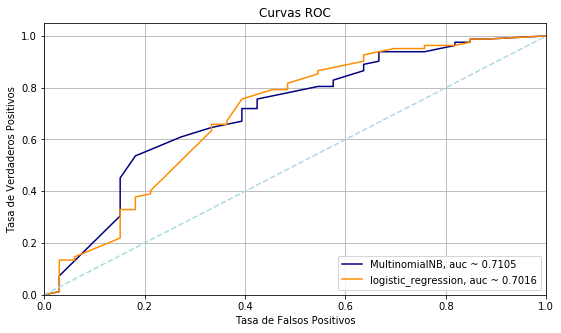

In [13]:
# Curvas ROC
plt.figure(figsize=(9,5))
plt.title('Curvas ROC')

plt.plot(fpr_game_nb, tpr_game_nb, color ='navy', label="MultinomialNB, auc ~ %0.4f" % auc_game_nb)
plt.plot(fpr_game_logit, tpr_game_logit, color = 'darkorange', label="logistic_regression, auc ~ %0.4f" % auc_game_logit)
# Estilo
plt.plot([0, 1], [0, 1], color='lightblue', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc =4)
plt.grid(True)
plt.show()

Para terminar este inciso, ahora presentamos las gráficas de precisión-exhaustividad para MultinomialNB y logistic_regression. 

Text(0, 0.5, 'Precisión')

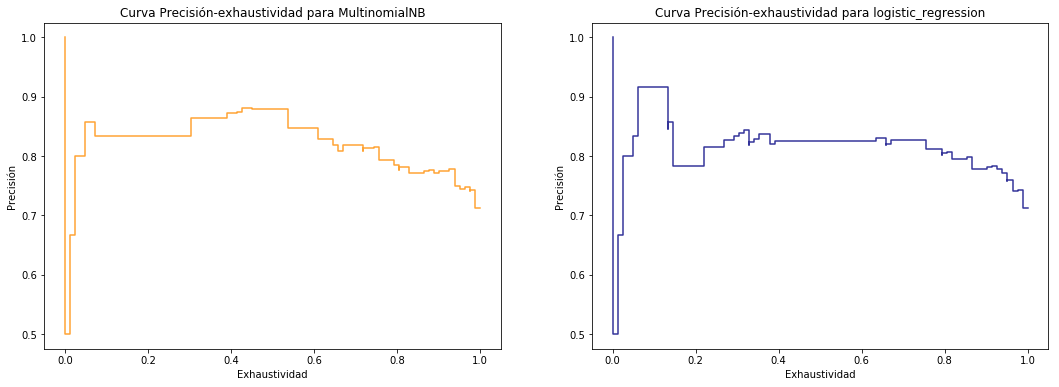

In [14]:
# Precisión-exhaustividad
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

gs = plt.GridSpec(1,2)
fig = plt.figure(figsize=(18,6))

# Precisión-Exhaustividad para MultinomialNB
precision_game_nb, recall_game_nb, _ = precision_recall_curve(test_responses, predicted_game_nb[0:,1])

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
fig.add_subplot(gs[0,0]).step(recall_game_nb, precision_game_nb, color='darkorange', alpha=0.8,
         where='post')
plt.title("Curva Precisión-exhaustividad para MultinomialNB")
plt.xlabel('Exhaustividad')
plt.ylabel('Precisión')


# Precisión-Exhaustividad para logistic_regression
precision_game_logit, recall_game_logit, _ = precision_recall_curve(test_responses, predicted_game_logit)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
fig.add_subplot(gs[0,1]).step(recall_game_logit, precision_game_logit, color='navy', alpha=0.8,
         where='post')
plt.title("Curva Precisión-exhaustividad para logistic_regression")
plt.xlabel('Exhaustividad')
plt.ylabel('Precisión')

## 3. Continuación de discusión
Podemos notar que el rendimiendo de ambos clasificadores MultnomialNB y logistic_regression  es muy similar y no muy bueno. Ambos no logran buenas predicciones sobre el conjunto de validación, siendo que para ambos baja mucho el score sobre este conjunto (de 0.8495297805642633 a 0.7217391304347827 para MultinomialNB y de 0.924764890282131 a 0.6608695652173913 para logistic_regression). Cabe mencionar también que se probaron los clasificadores bayesianoes ingenuos GaussianNB y BernoulliNB y ambos mostraron un comportamiento similar. 

No probamos entrenar directamente, i.e. sin aplicar la codificación, un clasificador bayesiano ingenuo con atributos con distribución categórica; aunque por la naturaleza del problema no vemos que el score sobre el conjunto de validación vaya a cambiar demasiado. 

Las preguntas sobre qué pasaría si aplicaramos regresión lineal a los datos originales ya fueron abordadas al inicio del ejercicio. 

Finalmente, es díficil decidir por alguno de los dos clasificadores ya que el rendimiento fue muy similar entre los dos. En el apsecto teórico, como opinión personal, el clasifcador bayesiano es más transparente ya que es capaz de trabajar directamente con los datos categóricos. 